<a href="https://colab.research.google.com/github/Junes94/toxic-comments-social-media/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dataset

In [2]:
import pandas as pd
import os
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
import re
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
src_path = '/content/drive/MyDrive/NMAproject_NLP_toxic/kaggle_dataset'

train_data = pd.read_csv(os.path.join(src_path,'train.csv'))
test_data =pd.read_csv(os.path.join(src_path,'test.csv'))

print(train_data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [6]:
original_train_data = pd.read_csv(os.path.join(src_path,'train.csv'))

In [ ]:
original_train_data

#Preprocess

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', text) # Remove IP addresses
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
train_data['comment_text'] = train_data['comment_text'].apply(preprocess_text)

# Vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_data['comment_text']).toarray()
y_train = train_data.iloc[:, 2:].values

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
X_train

In [ ]:
sum(X_train)

In [ ]:
sum(y_train)

In [ ]:
train_data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import classification_report

X_train, X_val_split, y_train, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)
prediction = clf.predict(X_val_split)
print('Accuracy Score: ', accuracy_score(y_val_split, prediction))
print('Hamming Loss: ', round(hamming_loss(y_val_split, prediction),2))
print(classification_report(y_val_split, prediction))

Accuracy Score:  0.920946263512455
Hamming Loss:  0.02
              precision    recall  f1-score   support

           0       0.91      0.63      0.74      3056
           1       0.57      0.26      0.36       321
           2       0.92      0.65      0.76      1715
           3       0.75      0.12      0.21        74
           4       0.83      0.54      0.65      1614
           5       0.74      0.18      0.29       294

   micro avg       0.88      0.57      0.69      7074
   macro avg       0.79      0.40      0.50      7074
weighted avg       0.87      0.57      0.69      7074
 samples avg       0.06      0.05      0.05      7074



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


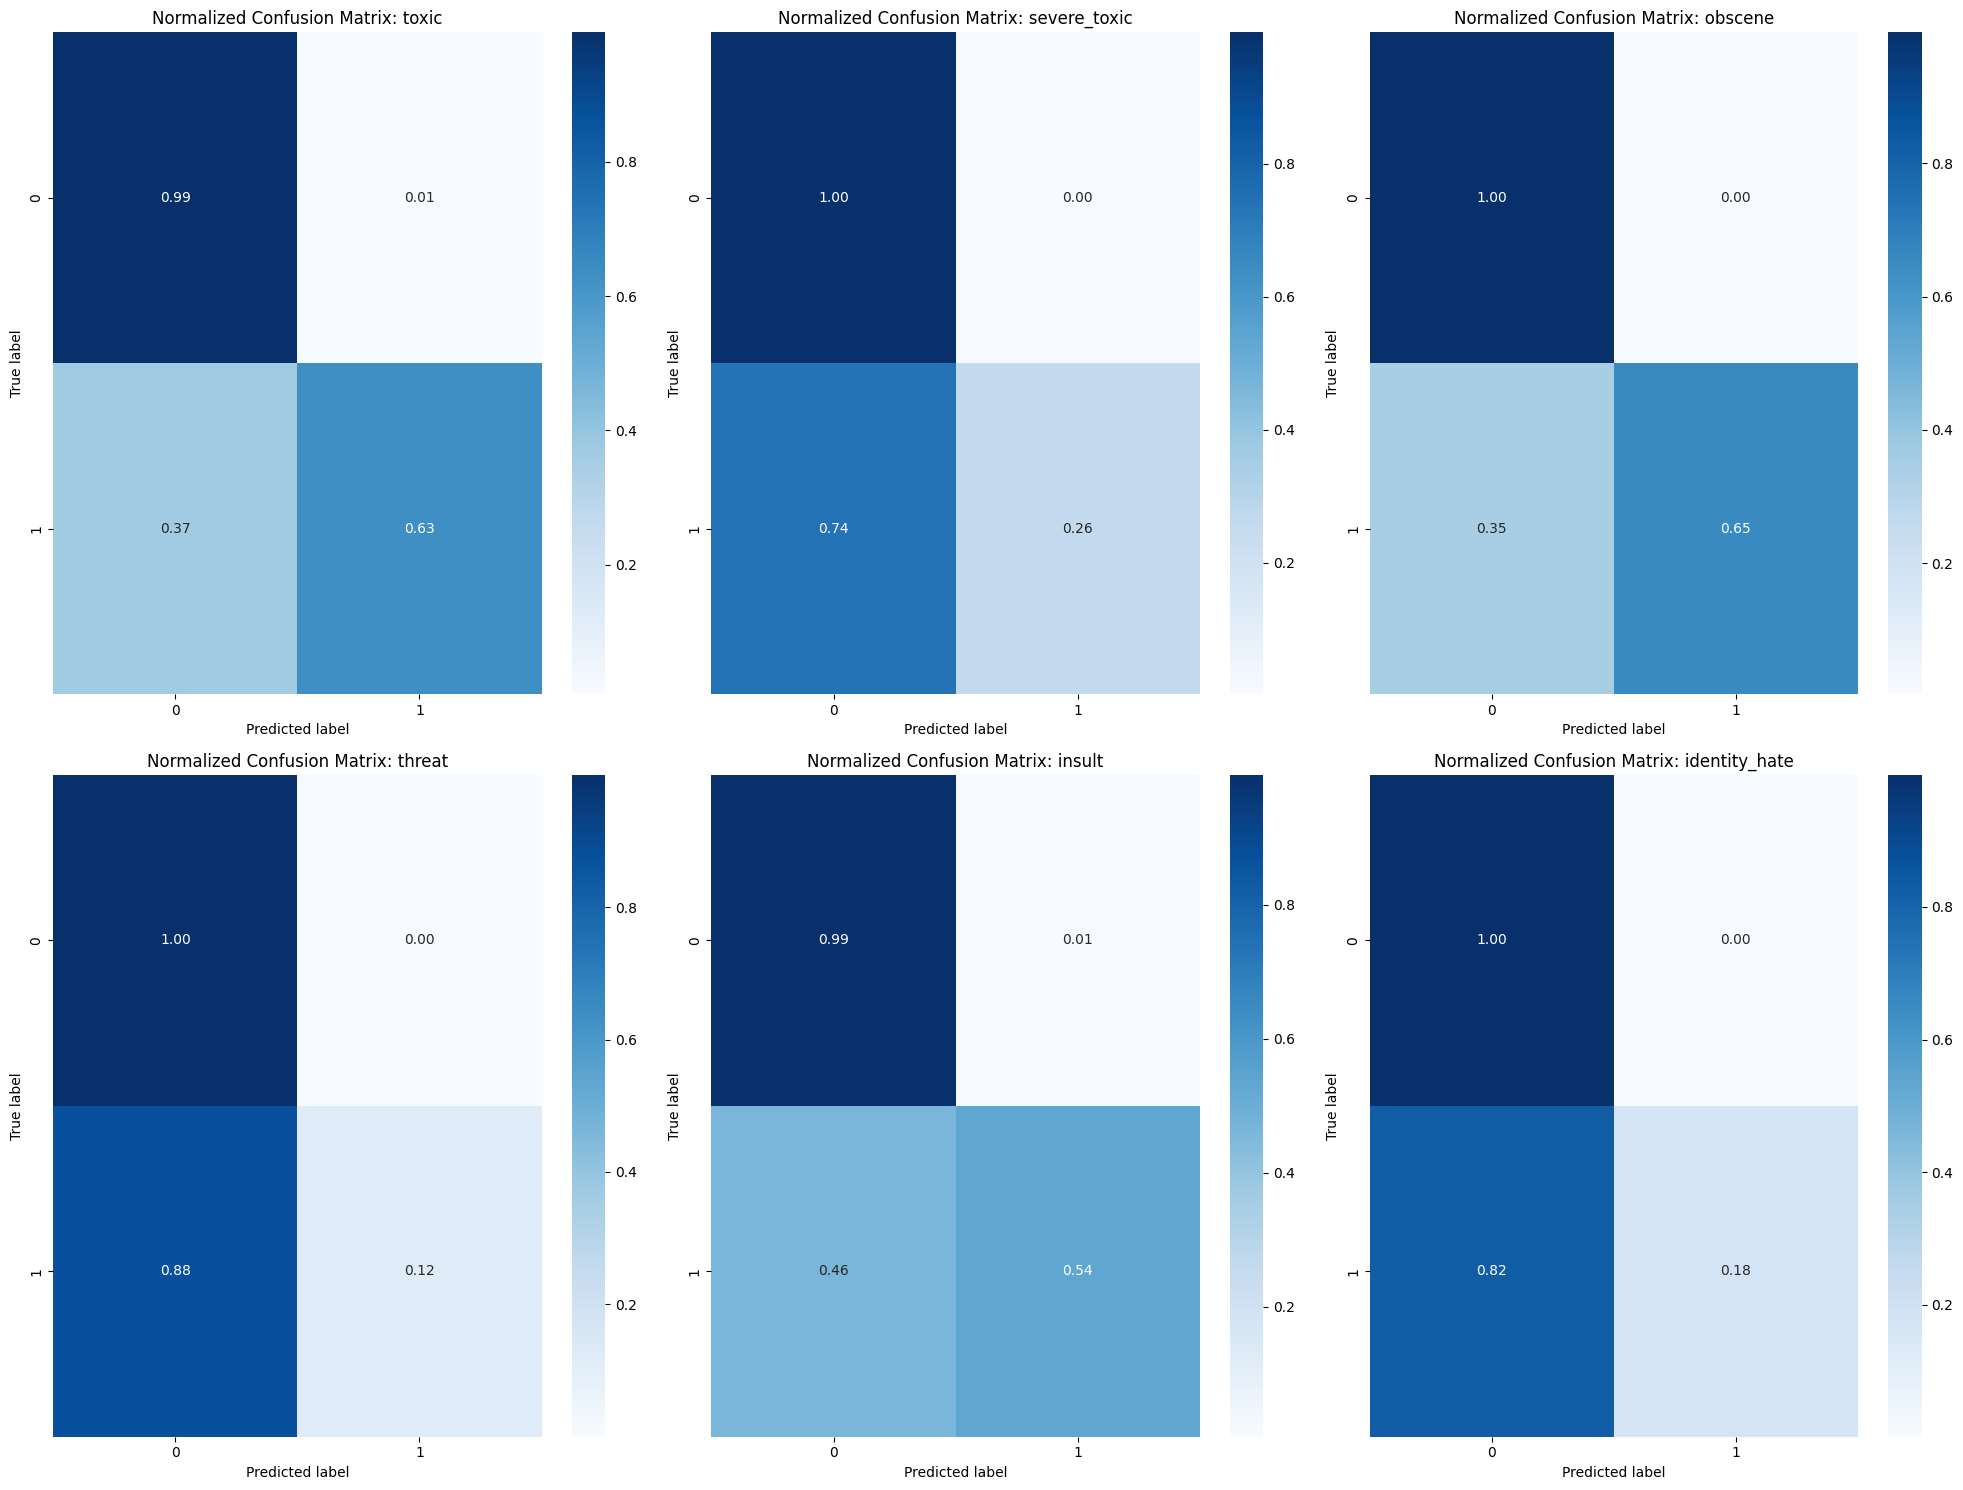

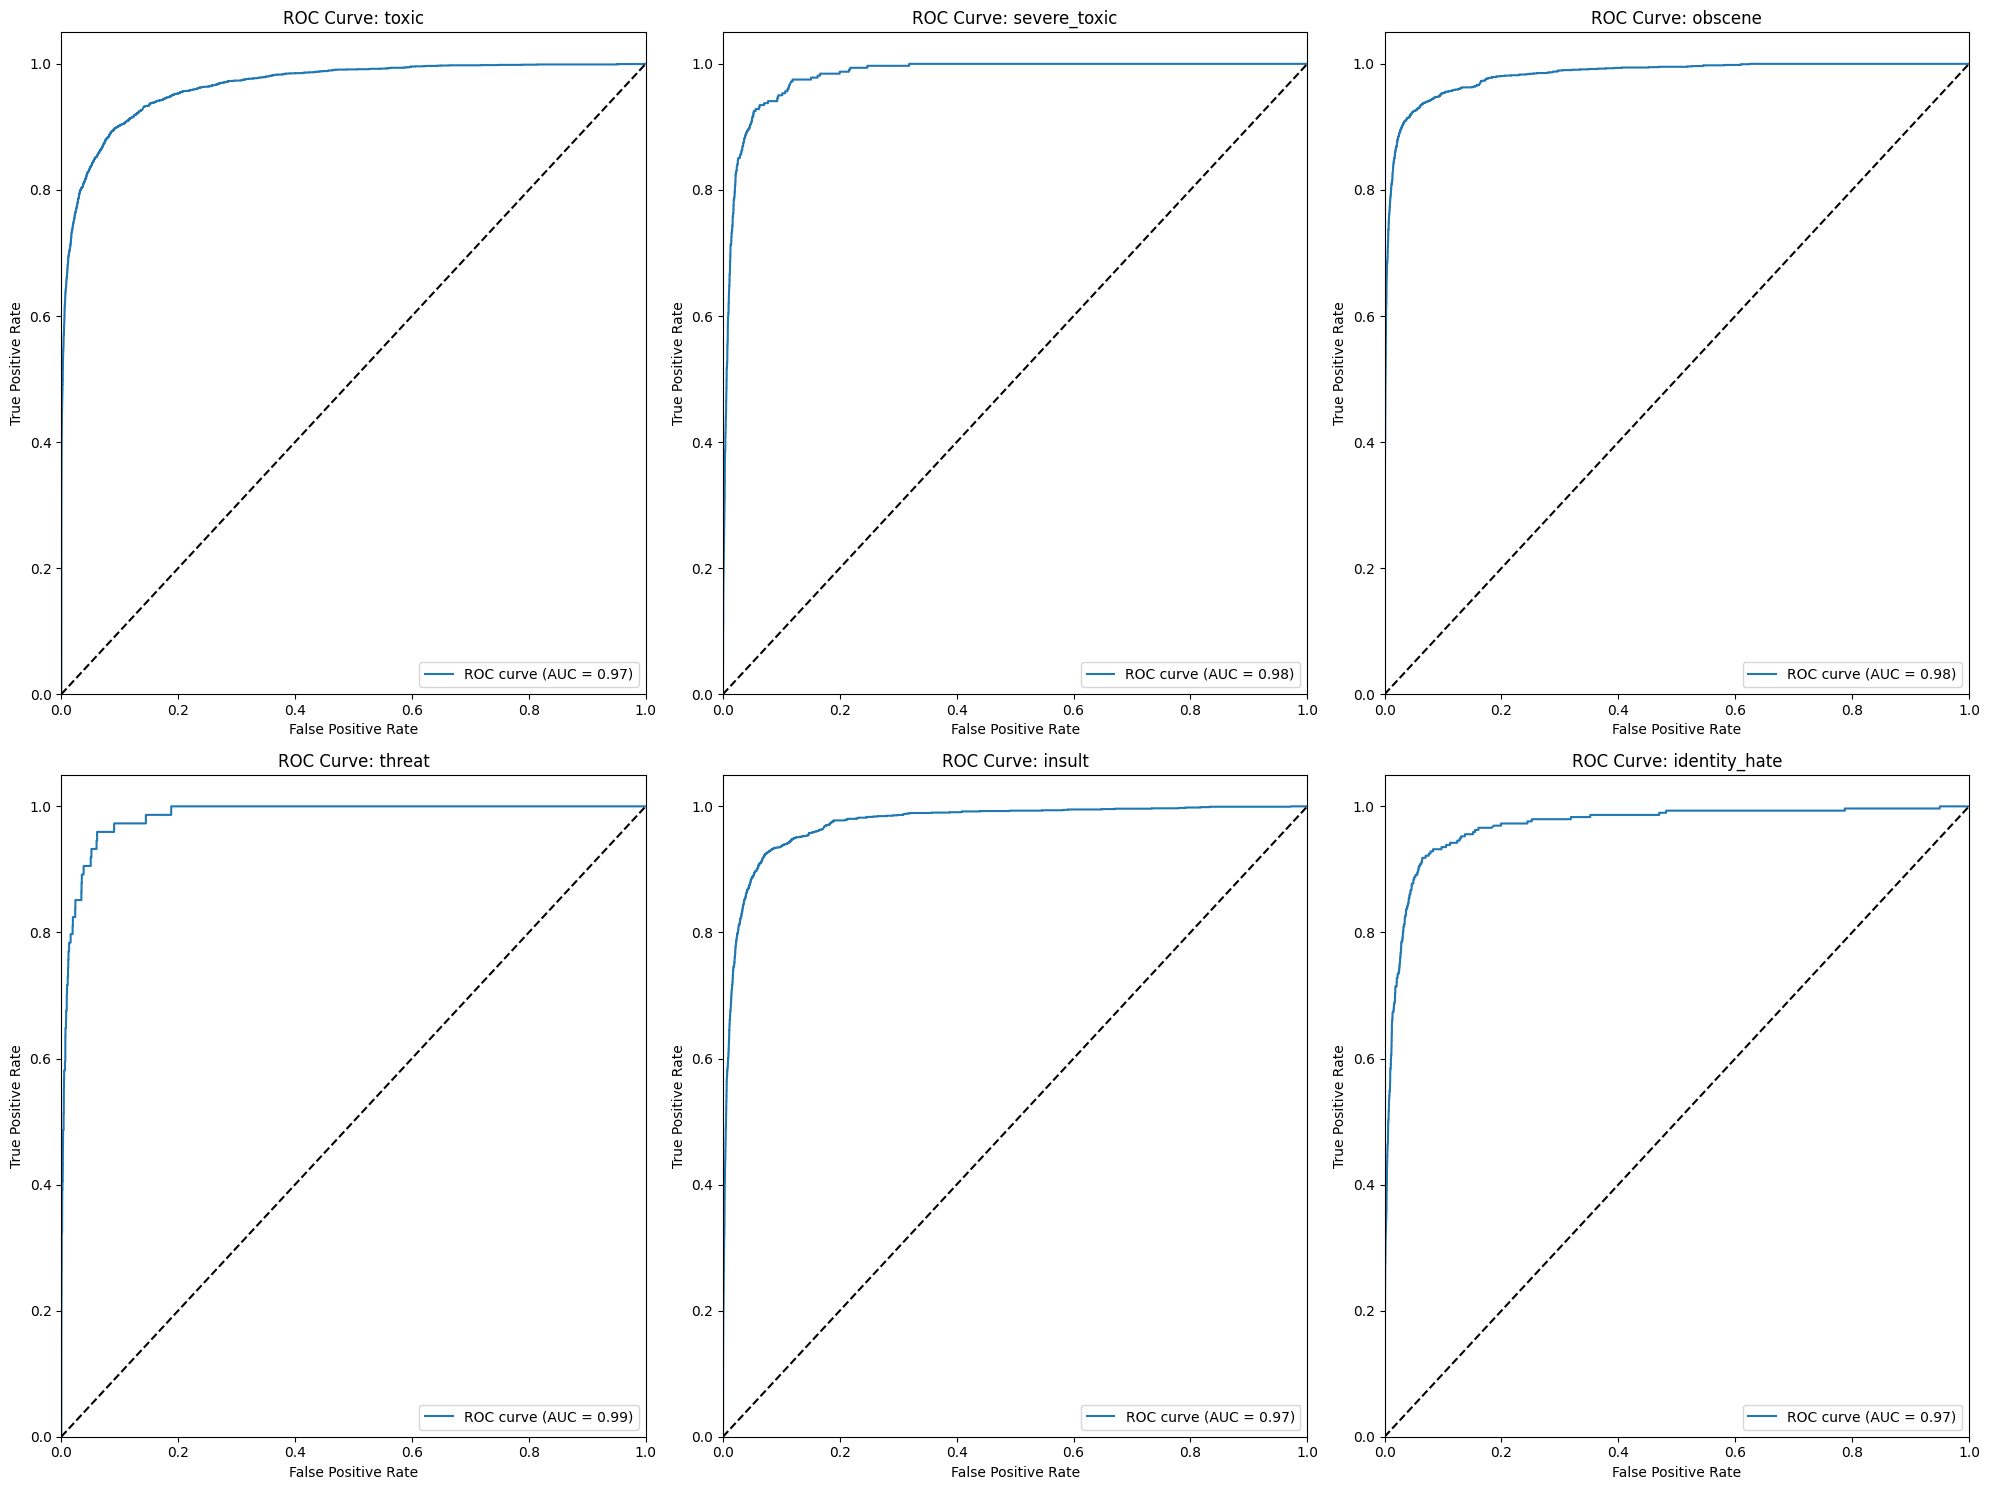

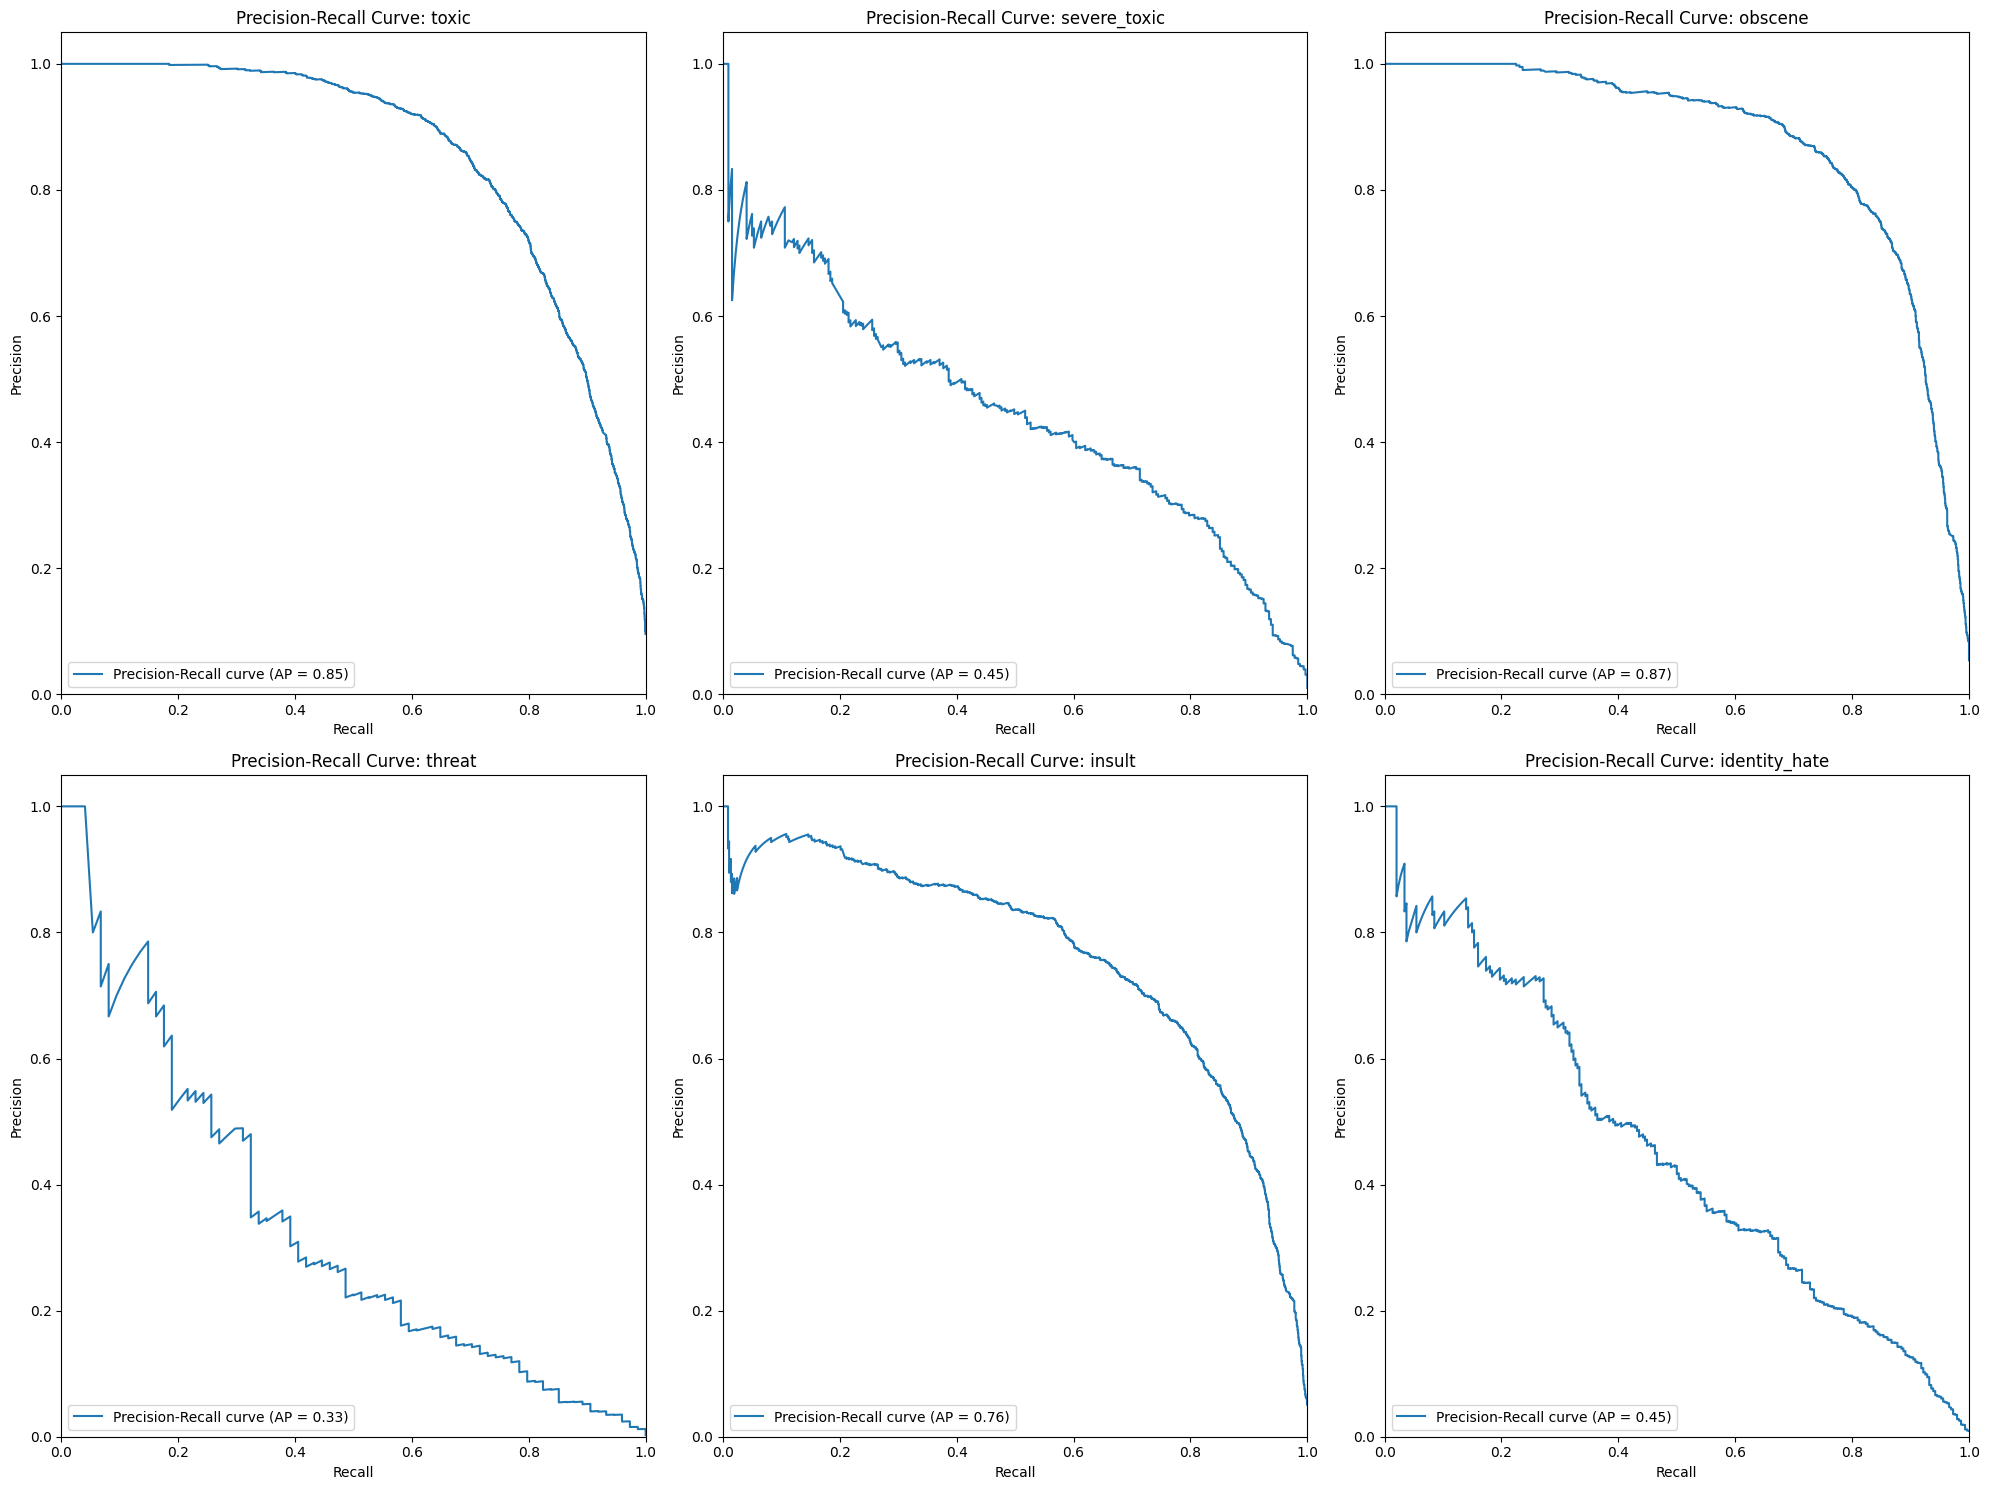

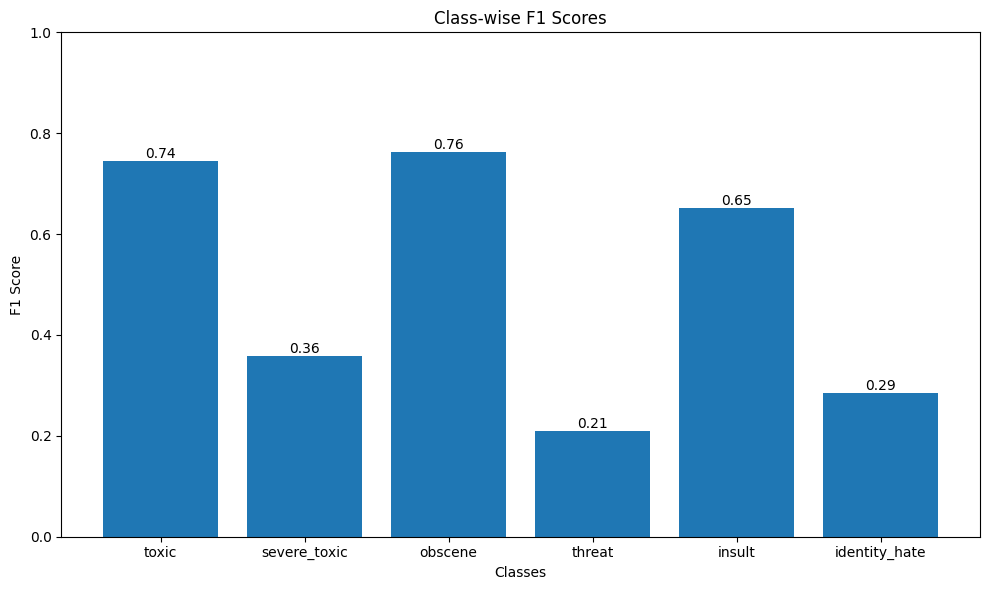

TypeError: got an unexpected keyword argument 'average'

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, accuracy_score
import numpy as np

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Normalized Confusion Matrix
plt.figure(figsize=(20, 15))
for i, class_name in enumerate(class_names):
    plt.subplot(2, 3, i+1)
    cm = confusion_matrix(y_val_split[:, i], prediction[:, i])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')  # fmt changed to '.2f'
    plt.title(f'Normalized Confusion Matrix: {class_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(20, 15))
for i, class_name in enumerate(class_names):
    plt.subplot(2, 3, i+1)
    y_pred_proba = clf.predict_proba(X_val_split)[i][:, 1]
    fpr, tpr, _ = roc_curve(y_val_split[:, i], y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {class_name}')
    plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(20, 15))
for i, class_name in enumerate(class_names):
    plt.subplot(2, 3, i+1)
    y_pred_proba = clf.predict_proba(X_val_split)[i][:, 1]
    precision, recall, _ = precision_recall_curve(y_val_split[:, i], y_pred_proba)
    average_precision = average_precision_score(y_val_split[:, i], y_pred_proba)
    plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {class_name}')
    plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# F1 score
f1_scores = [f1_score(y_val_split[:, i], prediction[:, i]) for i in range(len(class_names))]
plt.figure(figsize=(10, 6))
plt.bar(class_names, f1_scores)
plt.title('Class-wise F1 Scores')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

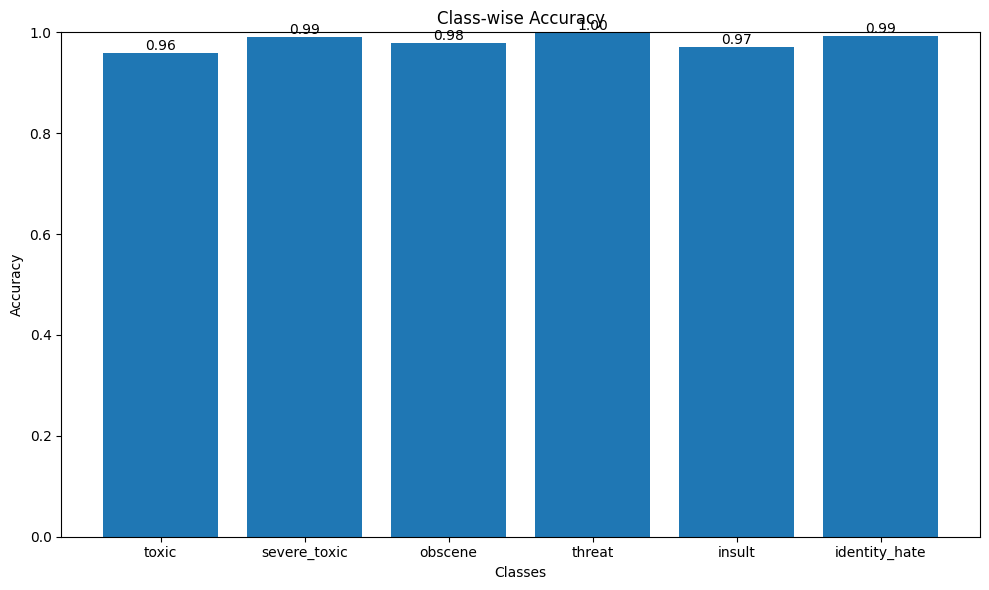

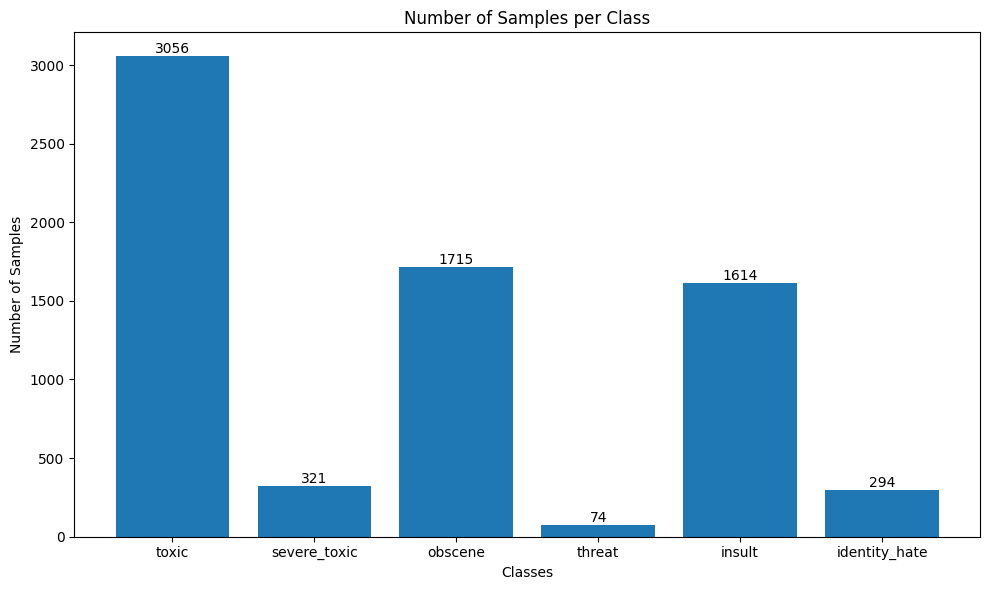

In [13]:
# Accuracy for each class
class_accuracy = [(y_val_split[:, i] == prediction[:, i]).mean() for i in range(len(class_names))]
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracy)
plt.title('Class-wise Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(class_accuracy):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Sample size for each class
class_samples = y_val_split.sum(axis=0)
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_samples)
plt.title('Number of Samples per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
for i, v in enumerate(class_samples):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()